In [1]:
%reload_ext autoreload
%autoreload 2

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from l2gv2.align.utils import to_device
from scipy.stats import special_ortho_group
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from umap import UMAP


# <font color="grey"> Graph Representation Learning at Scale</font>

#### <font color="grey">  Table of Contents</font>

1. <a href='#chapter1'>Structure</a>
2. <a href='#chapter2'>Datasets</a>
3. <a href='#chapter3'>Graphs</a>
4. <a href='#chapter4'>Patches</a>
5. <a href='#chapter5'>Embedding</a>
6. <a href='#chapter6'>Alignment</a>
7. <a href='#chapter7'>Hierarchical alignment</a>
8. <a href='#chapter8'>Visualisation</a>

###  <a id='chapter1'> <font color="grey">1. Structure </font></a>

There are five main parts to the package, organised as follows.

```
l2gv2/
├── datasets/
├── graphs/
├── patch/
├── embedding/
└── align/
    ├── l2g/
    └── geo/
```

A brief overview of the contents:

* ```datasets``` contains interfaces are provided for various common benchmark datasets. 
* ```graphs``` contains wrappers for graphs represented as lists of edges in pytorch-geometric ```data.edge_index``` format. These implemented features such as fast adjacency look-up and a variety of algorithms on graphs. Eventually, one could replace these with more sophisticad formats such as [Raphtory](https://www.raphtory.com/) graphs. 
* ```patch``` directory contains datastructures to represent patches and patch graphs, as well as methods to subdivide a graph into patches. 
* ```embedding``` contains various graph embedding methods, including Graph Autoencoders (GAE) and [Variational Graph Autoencoders (VGAE)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.VGAE.html).
* ```align``` contains two methods to compute the alignment of patches into a single graph embedding: eigenvalue synchronisation based on the [Local2Global](https://link.springer.com/article/10.1007/s10994-022-06285-7) algorithm, and the new method based on learning the alignment using a one-layer neural network.

###  <a id='chapter2'> <font color="grey">2. Datasets </font></a>

There are currently three datasets available:

* ```Cora```: The [Cora dataset](https://graphsandnetworks.com/the-cora-dataset/) is a dataset of 2708 scientific publications divided into 7 classes. The citation network consists of 5429 directed edges. To each publication / node there is an associated 1433-dimensional feature vector indicating the presence or absence of certain words. This dataset is accessed through the pytorch-geometric [Planetoid](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html) dataset.
* ```as-733```: The [SNAP autonomous systems AS-733](https://snap.stanford.edu/data/as-733.html) dataset contains 733 daily snapshots that span an interval of 785 days from November 8 1997 to January 2 2000. In each of these datasets, nodes represent autonomous systems and edges indicate whether communication has taken place. The resulting graph is undirected.
* ```mag240```: The [MAT240M](https://ogb.stanford.edu/docs/lsc/mag240m/) dataset is a large heterogeneous academic citation graph.
* ```elliptic```: The [Elliptic dataset](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set) maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph. The graph consists of 203,769 nodes representing transactions and 234,355 directed edges representing payments flows.
A case study is the paper [Anti-Money Laundering in Bitcoin: Experimenting with Graph
Convolutional Networks for Financial Forensics](https://arxiv.org/pdf/1908.02591) by Weber et.al.
* ```Dgraph```: [DGraph](https://dgraph.xinye.com/dataset) is a real world financial graph assembled for anomaly detection. This graph is described in the paper [DGraph: A Large-Scale Financial DAtaset for Graph Anomaly Detection](https://arxiv.org/abs/2207.03579).

These are accessed using the ```get_dataset``` function. The format of the datasets follows closely the [pytorch-geometric convention](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Dataset.html). If the data is not locally available, it is retreived and preprocessed into a specified directory. In the case of temporal (dynamic) graphs, the graphs are returned as an iterable over time slices. Ultimately, the graphs can be exported into formats such as raphtory or used to initialize ```TGraph``` instances (see <a href='#chapter3'>Chapter 3: Graphs</a>). Currently, only ```Cora```, ```as-733``` (temporal) and ```DGraph``` are available. The ```DGraph``` dataset needs to be downloaded manually and a path to the zip file provided as argument when first initialising it.

In [3]:
from l2gv2.datasets import get_dataset

In [4]:
cora = get_dataset("Cora")
print(cora[0])

Loading edge and node data from memory


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [5]:
# First transform data into raphtory format, then networkx for plotting.
G = cora.to("raphtory").to_networkx()

In [6]:
as733 = get_dataset("as-733")

Loading edge and node data from memory
Loading edge and node data from memory


In [7]:
g = as733.to("raphtory")

print("Stats on the graph structure:")

number_of_nodes = g.count_nodes()
number_of_edges = g.count_edges()
total_interactions = g.count_temporal_edges()

print("Number of nodes (AS nodes):", number_of_nodes)
print("Number of unique edges (src,dst):", number_of_edges)
print("Total interactions (edge updates):", total_interactions)

print("Stats on the graphs time range:")

earliest_datetime = g.earliest_date_time
latest_datetime = g.latest_date_time

print("Earliest datetime:", earliest_datetime)
print("Latest datetime:", latest_datetime)

Stats on the graph structure:
Number of nodes (AS nodes): 7716
Number of unique edges (src,dst): 45645
Total interactions (edge updates): 11965533
Stats on the graphs time range:
Earliest datetime: 1997-11-08 00:00:00+00:00
Latest datetime: 2000-01-02 00:00:00+00:00


In [8]:
# The Dgraph dataset requires registration. It needs to be downloaded from the website and placed in the data folder.
dgraph = get_dataset("DGraph", root="../data/dgraph", source_file="../data/DGraphFin.zip")
print(dgraph[0])

2025-03-26 10:01:11,026 - INFO - File ../data/dgraph/raw/DGraphFin.zip already exists in raw directory, skipping download


Loading edge and node data from memory


Data(x=[3700550, 17], edge_index=[2, 4300999], y=[3700550], edge_type=[4300999], edge_time=[4300999], train_mask=[3700550], val_mask=[3700550], test_mask=[3700550])


###  <a id='chapter3'> <font color="grey">3. Graphs </font></a>

There are three wrappers for graphs that were taken over from the local2global package: ```TGraph```, ```NPGraph``` and ```JitGraph```. These include, among other things, methods for fast adjacency look-up and various optimizations.

In [9]:
from l2gv2.graphs import TGraph

In [10]:
tg = TGraph(cora[0].edge_index, edge_attr=cora[0].edge_attr, x=cora[0].x)
print(tg.adj_index)
print(tg.x)

tensor([    0,     3,     6,  ..., 10548, 10552, 10556])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In a future iteration one can think about consolidating this part by having graphs represented in some existing graph package like Raphtory.

###  <a id='chapter4'> <font color="grey">4. Patches </font></a>

A patch can equivalently refer to a subgraph or to an embedding of this subgraph. As a set of points, a patch is represented using the ```Patch``` class. A ```Patch``` object has the properties ```nodes```, ```index``` and ```coordinates```. ```nodes``` is simply a list of the nodes from the original graph that are present in the patch. ```index``` is a dict that maps each node to an index into ```coordinates```, which is just a list of coordinates. For example, if a graph embedding consists of four nodes in two dimensions as follows, and a patch is represented by the solid circles, then the corresponding object would have the following properties:

![Patch](./images/square_patch.png)


In [11]:
from l2gv2.patch.patches import Patch

In [12]:
p = Patch([0,2,3], np.array([[0., 0.], [1., 0.], [1., 1.]]))
print(p.coordinates)
print(p.nodes)
print(p.index)

[[0. 0.]
 [1. 0.]
 [1. 1.]]
[0 2 3]
{0: 0, 2: 1, 3: 2}


In [14]:
from l2gv2.example import generate_patches, random_transform_patches, plot_patches

In [15]:
patches = generate_patches(n_points = 200, n_clusters=10)
n_patches = len(patches)
print(f"First 5 coordinates: {patches[0].coordinates[:5]}")
print(f"First 5 nodes: {patches[0].nodes[:5]}")
print(f"Indices: {patches[0].index}")

First 5 coordinates: [[-0.09659249 -0.56732859]
 [ 0.15658335 -0.82155376]
 [ 0.34838816 -0.69708304]
 [ 0.01302653 -0.29206633]
 [ 0.21635744 -0.46326141]]
First 5 nodes: [  1  12  82  99 100]
Indices: {1: 0, 12: 1, 82: 2, 99: 3, 100: 4, 117: 5, 154: 6, 173: 7, 265: 8, 314: 9, 336: 10, 417: 11, 451: 12, 582: 13, 643: 14, 646: 15, 699: 16, 749: 17, 787: 18, 791: 19, 793: 20, 795: 21, 801: 22, 804: 23, 808: 24, 809: 25, 811: 26, 815: 27, 816: 28, 819: 29, 823: 30, 830: 31, 834: 32, 836: 33, 837: 34, 840: 35, 841: 36, 848: 37, 854: 38, 858: 39, 864: 40, 867: 41, 869: 42, 872: 43, 875: 44, 884: 45, 890: 46, 892: 47, 895: 48, 901: 49, 902: 50, 903: 51, 907: 52, 909: 53, 910: 54, 914: 55, 917: 56, 927: 57, 931: 58, 932: 59, 933: 60, 937: 61, 941: 62, 944: 63, 948: 64, 949: 65, 951: 66, 952: 67, 954: 68, 956: 69, 958: 70, 960: 71, 961: 72, 962: 73, 963: 74, 964: 75, 966: 76, 968: 77, 969: 78, 971: 79, 973: 80, 976: 81, 977: 82, 978: 83, 979: 84, 982: 85, 983: 86, 984: 87, 985: 88, 986: 89, 9

The crucial feature of patches is that different patches may reference the same node in an underlying graph, but with different coordiantes. A typical 

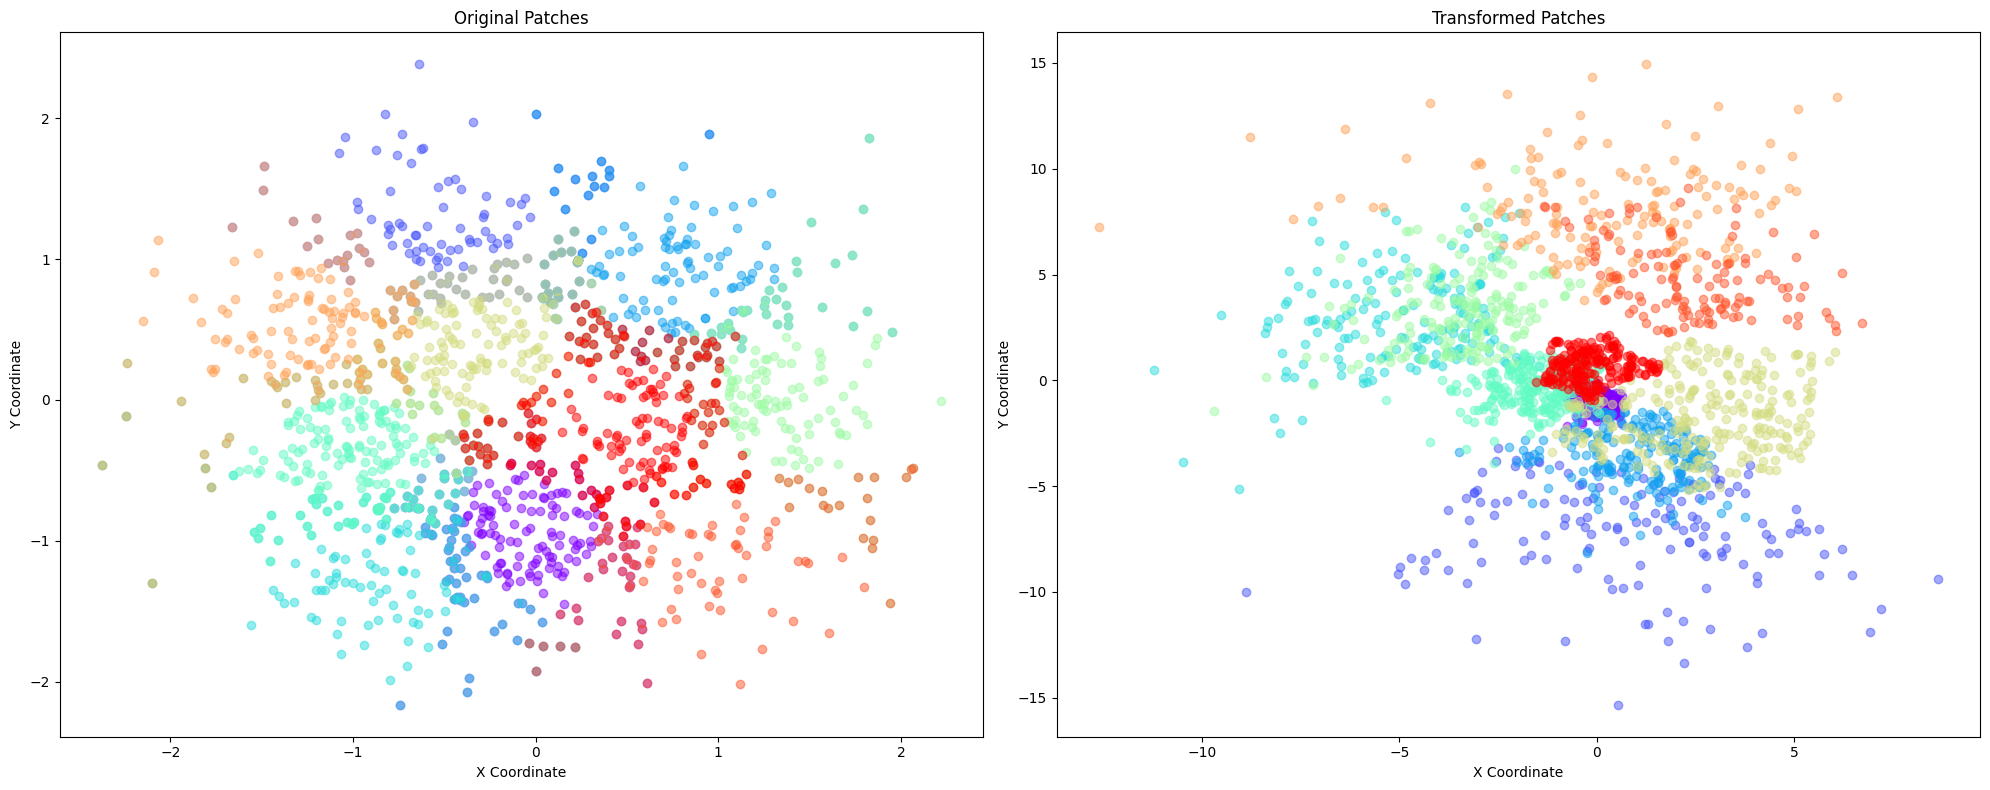

In [16]:
# Apply random shifts and rotations to the patches
transformed_patches = random_transform_patches(patches)
plot_patches(patches, transformed_patches)

The patches from the nodes of a **patch graph**, where two nodes are connected by an edge if the patches contain overlapping nodes. The alignment tasks consists of making the correponding coordinates overlap as much as possible.

###  <a id='chapter5'> <font color="grey">5. Alignment </font></a>

We have a way of representing patches and a way of embedding them. The next step is to compute the alignment based on the patch graph. There are two methods for this, we focus on the 'new' one.

In [111]:
np.random.seed(42)  # For reproducibility
points = np.random.rand(100, 2)
patches = [Patch([i for i in range(60)], points[:60]),
           Patch([i for i in range(40,100)], points[-60:])]

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


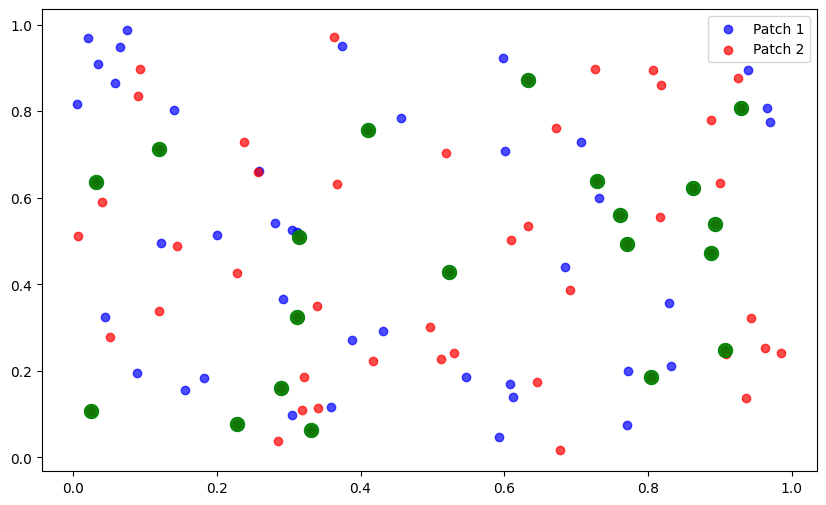

In [112]:

plt.figure(figsize=(10, 6))
plt.scatter(patches[0].coordinates[:, 0], patches[0].coordinates[:, 1], c='blue', alpha=0.7, label='Patch 1')
plt.scatter(patches[1].coordinates[:, 0], patches[1].coordinates[:, 1], c='red', alpha=0.7, label='Patch 2')
plt.legend()
overlap_indices = list(set(patches[0].nodes.tolist()).intersection(set(patches[1].nodes.tolist())))
print(overlap_indices)
if overlap_indices:
    overlap_coords_patch0 = patches[0].get_coordinates(overlap_indices)
    overlap_coords_patch1 = patches[1].get_coordinates(overlap_indices)
    plt.scatter(overlap_coords_patch0[:, 0], overlap_coords_patch0[:, 1], c='green', s=100, alpha=0.7, label='Overlap')
plt.scatter(overlap_coords_patch0[:, 0], overlap_coords_patch0[:, 1], c='green', s=100, alpha=0.7, label='Overlap')  # Increased size from 100 to 200
plt.show()


In [113]:
rotation = special_ortho_group.rvs(2)  # 2x2 random orthogonal matrix
scale = np.random.uniform(0.5, 2.0)
translation = np.random.uniform(-5, 5, size=2)
set2_transformed = scale * (patches[1].coordinates @ rotation.T) + translation
transformed_patches = [patches[0], Patch(patches[1].nodes, set2_transformed)]

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


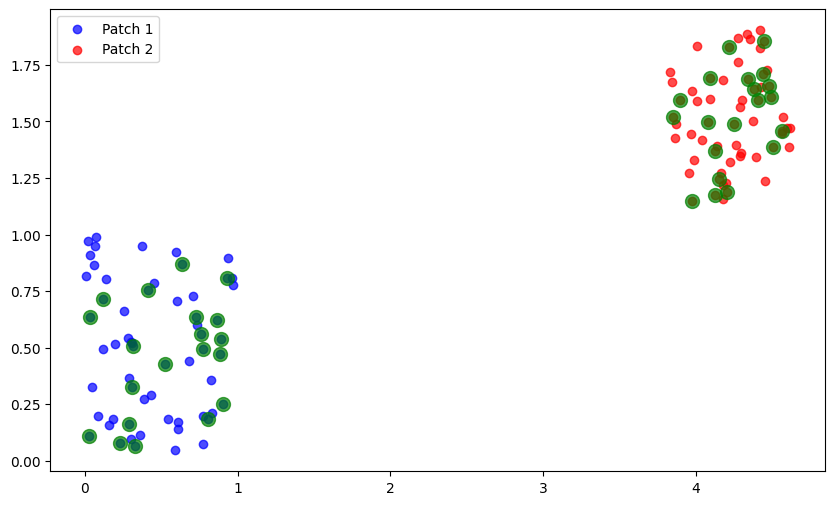

In [114]:
plt.figure(figsize=(10, 6))
plt.scatter(transformed_patches[0].coordinates[:, 0], transformed_patches[0].coordinates[:, 1], c='blue', alpha=0.7, label='Patch 1')
plt.scatter(transformed_patches[1].coordinates[:, 0], transformed_patches[1].coordinates[:, 1], c='red', alpha=0.7, label='Patch 2')
plt.legend()
overlap_indices = list(set(transformed_patches[0].nodes.tolist()).intersection(set(transformed_patches[1].nodes.tolist())))
print(overlap_indices)
if overlap_indices:
    overlap_coords_patch0 = transformed_patches[0].get_coordinates(overlap_indices)
    overlap_coords_patch1 = transformed_patches[1].get_coordinates(overlap_indices)
    plt.scatter(overlap_coords_patch0[:, 0], overlap_coords_patch0[:, 1], c='green', s=100, alpha=0.7, label='Overlap')
    plt.scatter(overlap_coords_patch1[:, 0], overlap_coords_patch1[:, 1], c='green', s=100, alpha=0.7, label='Overlap')
plt.show()

For the patch graph, we first determine the intersections. 

In [116]:
def get_intersections(patches, min_overlap=0):
    """Calculate the intersection of nodes between patches."""
    intersections = {}
    embeddings = {}
    for i, _ in enumerate(patches):
        for j in range(i + 1, len(patches)):
            intersections[(i, j)] = list(
                set(patches[i].nodes.tolist()).intersection(
                    set(patches[j].nodes.tolist())
                )
            )
            if len(intersections[(i, j)]) >= min_overlap:
                embeddings[(i, j)] = [
                    torch.tensor(
                        patches[i].get_coordinates(list(intersections[(i, j)]))
                    ),
                    torch.tensor(
                        patches[j].get_coordinates(list(intersections[(i, j)]))
                    ),
                ]
    # embeddings = list(itertools.chain.from_iterable(embeddings))
    return intersections, embeddings

In [117]:
intersections, embeddings = get_intersections(transformed_patches, min_overlap=3)

There is only one edge connecting the two patches.

In [118]:
class AffineModel(nn.Module):
    """
    Model for aligning patch embeddings
    """

    def __init__(self, dim, n_patches, device):
        """
        Initialize the model
        Args:
            dim: int
            n_patches: int
            device: str
        """
        super().__init__()
        self.device = device
        linear_layers = [nn.Linear(dim, dim, bias=True).to(device) for _ in range(n_patches)]
        # Fix the first transformation to be the identity
        fixed_layer_index = 0
        linear_layers[fixed_layer_index].weight.data.copy_(torch.eye(dim))
        linear_layers[fixed_layer_index].bias.data.zero_()
        linear_layers[fixed_layer_index].weight.requires_grad = False
        linear_layers[fixed_layer_index].bias.requires_grad = False

        self.transformation = nn.ParameterList(linear_layers)

    def forward(self, patch_intersection):
        """
        Forward pass
        """
        outputs = {}
        for (i, j), (X, Y) in patch_intersection.items():
            Xt = self.transformation[i](X)
            Yt = self.transformation[j](Y)
            outputs[(i, j)] = (Xt, Yt)
        return outputs

In [119]:
def patchgraph_mse_loss(transformed_emb):
    total_loss = 0.0
    for (_, _), (transformed_X, transformed_Y) in transformed_emb.items():
        pair_loss = F.mse_loss(transformed_X, transformed_Y, reduction="sum")
        total_loss += pair_loss
    return total_loss

In [120]:
dim = 2
device = "cpu"
model = AffineModel(dim, n_patches, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-1)
loss_hist = []
patch_emb = to_device(embeddings, "cpu")


In [121]:
for epoch in range(2000):
    optimizer.zero_grad()
    transformed_patch_emb = model(patch_emb)
    loss = patchgraph_mse_loss(transformed_patch_emb)
    loss.backward(retain_graph=True)
    optimizer.step()
    loss_hist.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 32.07548904418945
Epoch 100, Loss: 1.7092839479446411
Epoch 200, Loss: 0.8782651424407959
Epoch 300, Loss: 0.5802803635597229
Epoch 400, Loss: 0.35716286301612854
Epoch 500, Loss: 0.2025894969701767
Epoch 600, Loss: 0.1061512678861618
Epoch 700, Loss: 0.051422107964754105
Epoch 800, Loss: 0.02302367612719536
Epoch 900, Loss: 0.009518048726022243
Epoch 1000, Loss: 0.003626779653131962
Epoch 1100, Loss: 0.001271001878194511
Epoch 1200, Loss: 0.0004085324762854725
Epoch 1300, Loss: 0.00012006373435724527
Epoch 1400, Loss: 3.214487151126377e-05
Epoch 1500, Loss: 7.806578651070595e-06
Epoch 1600, Loss: 1.7127616729339934e-06
Epoch 1700, Loss: 3.380714019840525e-07
Epoch 1800, Loss: 5.9382095685123204e-08
Epoch 1900, Loss: 9.297044911704688e-09


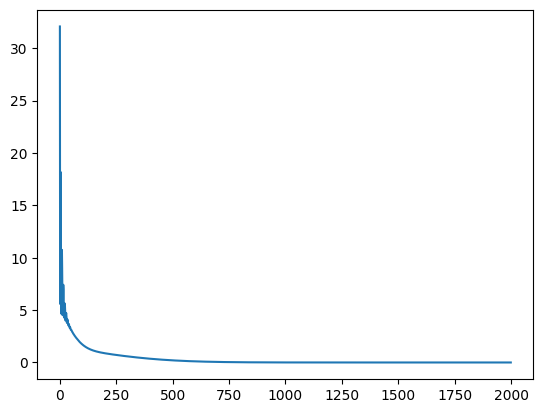

In [122]:
plt.plot(loss_hist)
plt.show()

In [123]:
recoverd_patches_coordinates = [
    transformed_patches[i].coordinates @ model.transformation[i].weight.data.detach().numpy().T
    + model.transformation[i].bias.data.detach().numpy()
    for i in range(2)
]
recoverd_patches = [Patch(transformed_patches[i].nodes, recoverd_patches_coordinates[i]) for i in range(2)]


[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


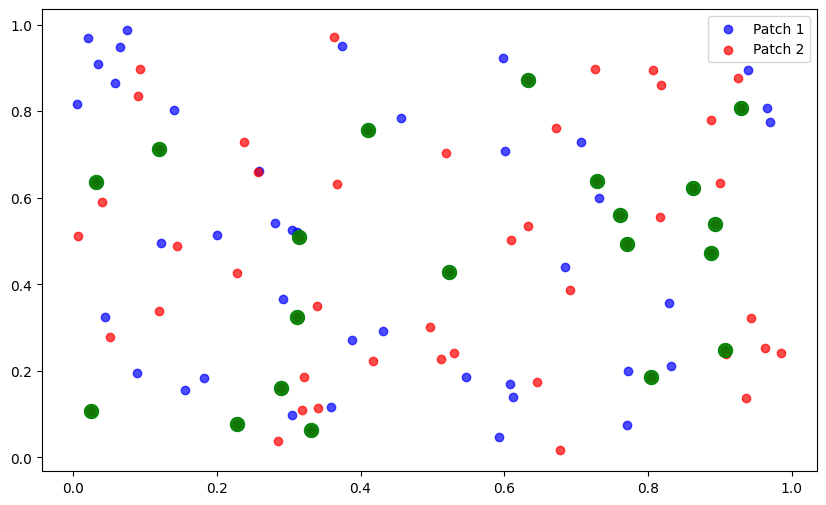

In [124]:
plt.figure(figsize=(10, 6))
plt.scatter(recoverd_patches[0].coordinates[:, 0], recoverd_patches[0].coordinates[:, 1], c='blue', alpha=0.7, label='Patch 1')
plt.scatter(recoverd_patches[1].coordinates[:, 0], recoverd_patches[1].coordinates[:, 1], c='red', alpha=0.7, label='Patch 2')
plt.legend()
overlap_indices = list(set(recoverd_patches[0].nodes.tolist()).intersection(set(recoverd_patches[1].nodes.tolist())))
print(overlap_indices)
if overlap_indices:
    overlap_coords_patch0 = recoverd_patches[0].get_coordinates(overlap_indices)
    overlap_coords_patch1 = recoverd_patches[1].get_coordinates(overlap_indices)
    plt.scatter(overlap_coords_patch0[:, 0], overlap_coords_patch0[:, 1], c='green', s=100, alpha=0.7, label='Overlap')
    plt.scatter(overlap_coords_patch1[:, 0], overlap_coords_patch1[:, 1], c='green', s=100, alpha=0.7, label='Overlap')
plt.show()

In [136]:
from l2gv2.align import get_aligner

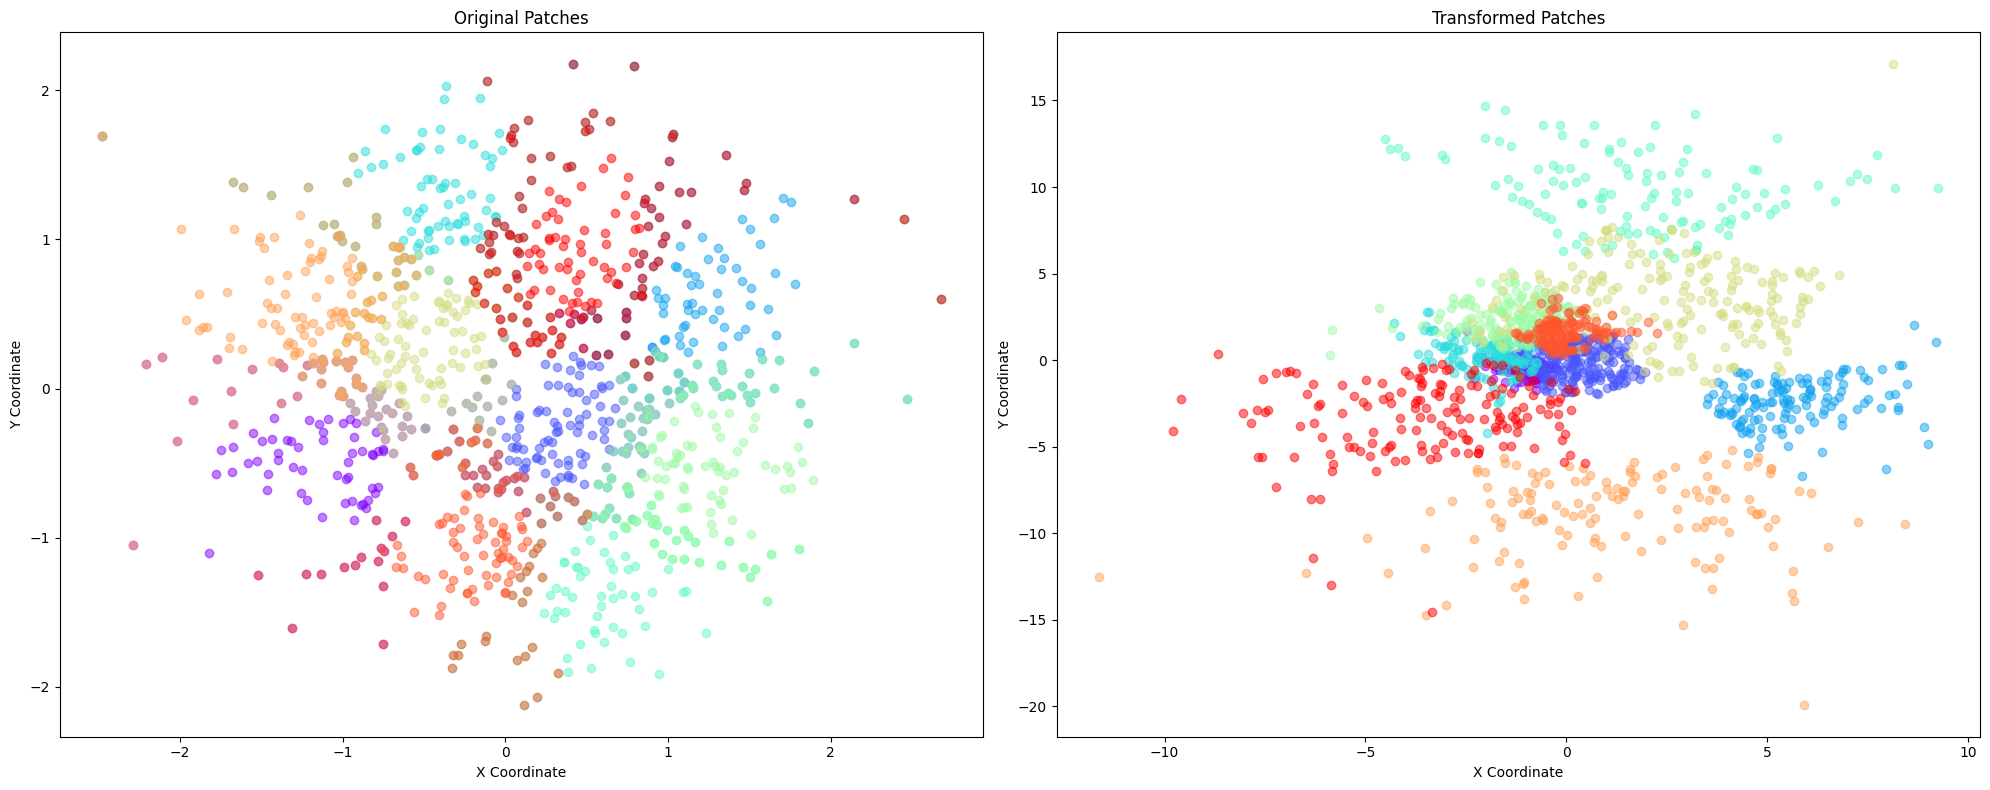

In [137]:
patches = generate_patches(n_points = 200, n_clusters=10)
n_patches = len(patches)
transformed_patches = random_transform_patches(patches)
plot_patches(patches, transformed_patches)

Compute mean embedding:   0%|          | 0/10 [00:00<?, ?it/s]

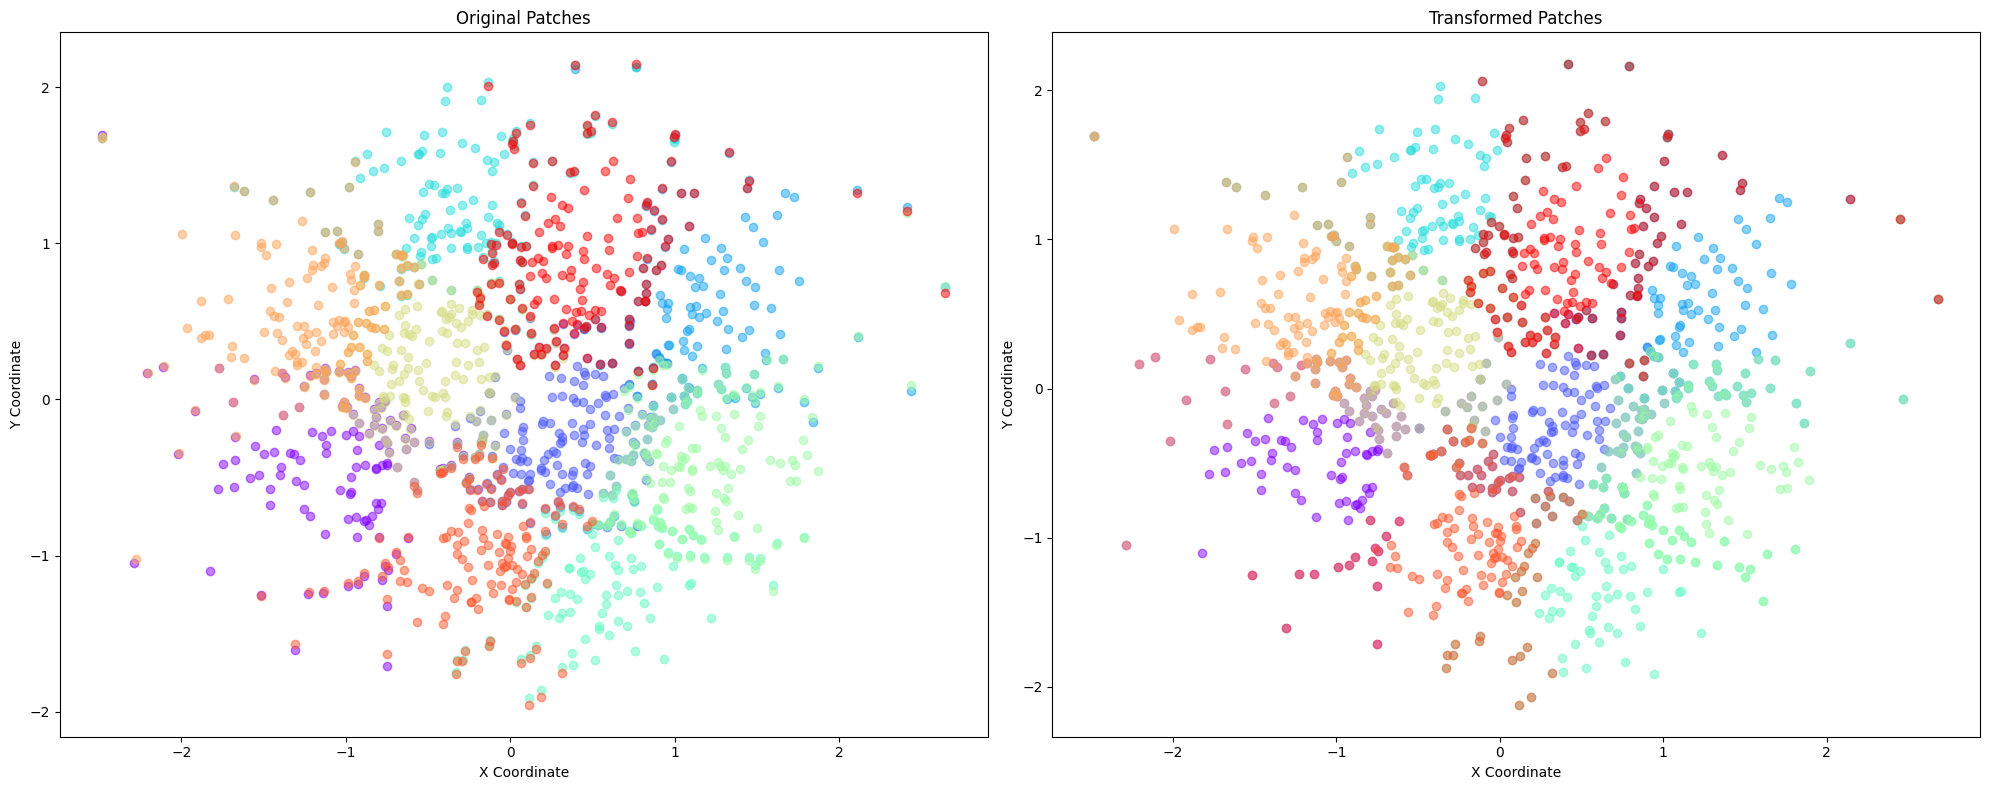

In [146]:
geo_aligner = get_aligner(
    "geo", 
    patches=transformed_patches,
    num_epochs=500,
    learning_rate=0.1,
    model_type="affine")
embedding = geo_aligner.get_aligned_embedding()
plot_patches(geo_aligner.patches, patches)

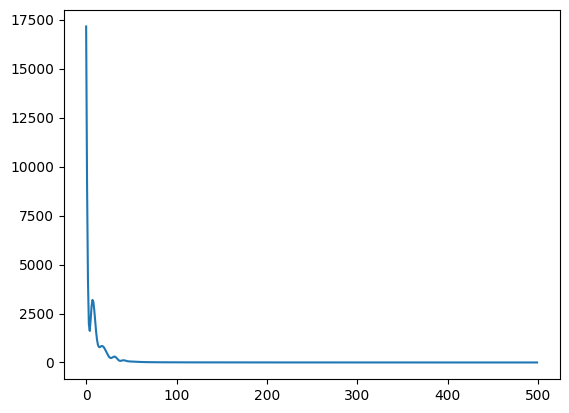

In [141]:
plt.plot(geo_aligner.loss_hist)
plt.show()

###  <a id='chapter6'> <font color="grey">6. Embedding </font></a>

The coordinates of a patch come from an embedding of a graph into Euclidean space. 
For the embedding, we use the architecture of a Variational Graph Autoencoder. Given a graph $G=(V,E)$ with $|V|=n$ nodes and node features ${x}_i\in \mathbb{R}^d$, $i\in [n]$, denote by ${X}=[{x}_1,\dots,{x}_n]^T\in \mathbb{R}^{n\times d}$ the features matrix and by $A=(a_{ij})\in \{0,1\}^{n\times n}$ the adjacency matrix of the graph. The **encoder** produces latent representations ${z}_i\in \mathbb{R}^k$ for $i\in [n]$, which are sampled from the inference model
\begin{equation*}
  q({z}_i \ | \ {X},{A}) = \mathcal{N}({z}_i \ | \ {\mu}_i,\mathrm{diag}({\sigma}_i)).
\end{equation*}
The means $\mu_i$ and variances $\mathrm{diag}({\sigma}_i)$ are parametrized using an encoder network, for example, a graph convolutional neural network (GCN). Denoting by ${Z}=[{z}_1,\dots,{z}_n]^T$ the matrix of latent represenations and by ${\mu}$ and ${\sigma}$ the matrices representing the means and variances, we have
\begin{equation*}
  {\mu} = \mathrm{GCN}_{\mu}({X},{A}), \quad \quad \log {\sigma} = \mathrm{GCN}_{\sigma}({X},{A}).
\end{equation*}
The **generative model** is a distribution on the adjacency matrix,
\begin{equation*}
  p({A}\ | \ {Z}) = \prod_{i,j} p(a_{ij} \ | \ {z}_i,{z}_j).
\end{equation*}
It is convenient to use
\begin{equation*}
  p(a_{ij}=1 \ | \ {z}_i,{z}_j) = \sigma({z}_i^T{z}_j),
\end{equation*}
where $\sigma$ is the logistic sigmoid. In order to train the model, we optimize the evidence lower bound
\begin{equation*}
  \mathcal{L} = \mathbb{E}_{q({Z}\ | \ {X},{A})}[\log p({A}\ | \ {Z})]-\mathrm{D}_{\mathrm{KL}}(q({Z}\ | \ {X},{A}) \ \| \ p({Z})).
\end{equation*}

In [142]:
from l2gv2.embedding.gae import VGAE
from l2gv2.embedding.train import train
from l2gv2.embedding.gae.utils.loss import VGAE_loss

In [143]:
model = VGAE(dim=64, hidden_dim=128, num_features=tg.x.shape[1]).to(device)
model = train(cora[0], model, loss_fun=VGAE_loss, num_epochs=200, verbose=False, lr=0.001)
with torch.no_grad():
    model.eval()
    coordinates = model.encode(cora[0]).to("cpu").numpy()

In [144]:
reducer = UMAP(n_components=2, random_state=42)
umap_data = reducer.fit_transform(coordinates)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


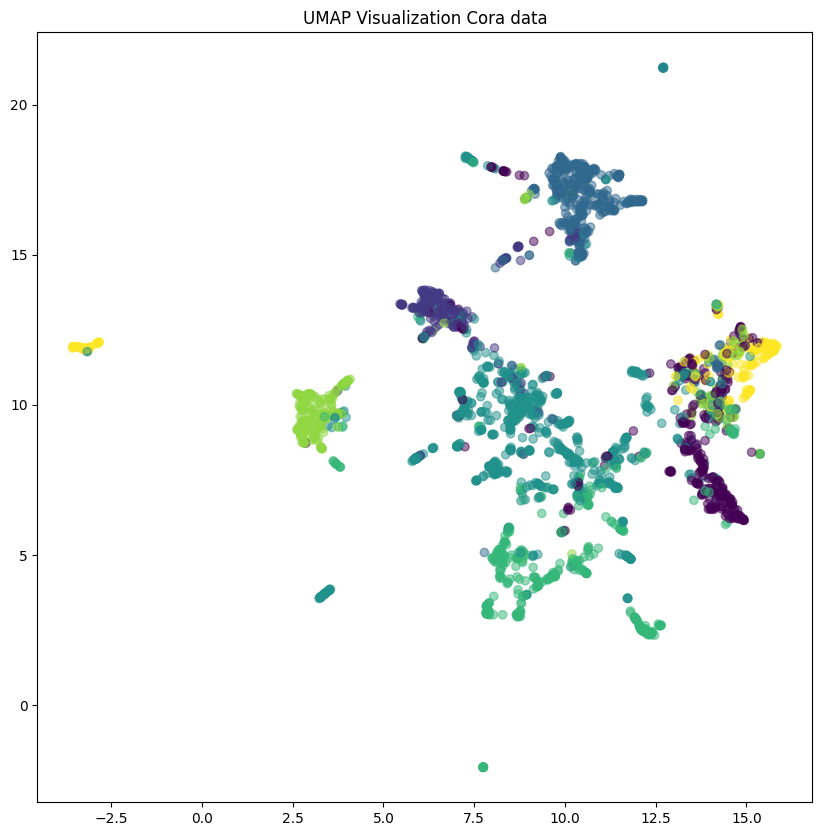

In [145]:
plt.figure(figsize=(10, 10))
plt.scatter(umap_data[:, 0], umap_data[:, 1], c=cora[0].y, cmap='viridis', alpha=0.5)
plt.title('UMAP Visualization Cora data')
plt.show()

###  <a id='chapter7'> <font color="grey">7. Hierarchical alignment </font></a>

To be done.

###  <a id='chapter8'> <font color="grey">8. Visualisation </font></a>

For the visualisation, it is convenient to use external packages such as Heimdall.